In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import os
import json
import sys
import numpy as np
sys.path.append("..")
import copy
from tqdm.auto import tqdm

In [3]:
from src import models, data, operators, utils, functional, metrics, lens
from src.utils import logging_utils, experiment_utils
import logging
import torch
import baukit
import random
import numpy as np
import torch
experiment_utils.set_seed(123456)

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.INFO,
    format = logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout
)

In [4]:
#################################################
h_layer = 7
beta = 2.5
n_training = 10
#################################################

In [5]:
mt = models.load_model(name = "gptj", fp16 = True, device = "cuda")

2023-06-27 12:52:06 src.models INFO     loading EleutherAI/gpt-j-6B (device=cuda, fp16=True)


In [6]:
relation = data.load_dataset().filter(relation_names=["country capital city"])[0].set(prompt_templates=[" {}:"])
train, test = relation.split(n_training)

In [7]:
icl_prompt = functional.make_prompt(
    prompt_template = train.prompt_templates[0],
    subject = "{}",
    examples = train.samples,
    mt = mt
)
print(icl_prompt)

<|endoftext|> Pakistan: Islamabad
 Argentina: Buenos Aires
 Peru: Lima
 Australia: Canberra
 Germany: Berlin
 Saudi Arabia: Riyadh
 Russia: Moscow
 Italy: Rome
 India: New Delhi
 South Korea: Seoul
 {}:


In [8]:
test = functional.filter_relation_samples_based_on_provided_fewshots(
    mt = mt, 
    test_relation=test,
    prompt_template = icl_prompt,
    batch_size=4
)
len(test.samples)

14

In [9]:
estimator = operators.JacobianIclMeanEstimator(
    mt = mt, h_layer=h_layer, beta=beta
)
operator = estimator(train)

In [17]:
operator_dict = operator.__dict__.copy()
operator_dict["beta"] = 1.0
no_beta = operators.LinearRelationOperator(**operator_dict)

In [19]:
for sample in test.samples:
    pred = operator(sample.subject).predictions[:3]
    no_beta_pred = no_beta(sample.subject).predictions[:3]
    print(f"{sample} | pred: {[f'{p.token} ({p.prob:.2f})' for p in pred]} | no_beta: {[f'{p.token} ({p.prob:.2f})' for p in no_beta_pred]}")

Brazil -> Bras\u00edlia | pred: [' Bras (0.74)', ' Rio (0.11)', ' Sao (0.04)'] | no_beta: ['  (0.26)', ' New (0.11)', ' Bras (0.06)']
Canada -> Ottawa | pred: [' Toronto (0.28)', ' Ottawa (0.23)', ' Vancouver (0.10)'] | no_beta: ['  (0.22)', ' New (0.18)', ' Washington (0.08)']
Chile -> Santiago | pred: [' Santiago (0.98)', '  (0.01)', ' Chile (0.01)'] | no_beta: ['  (0.34)', ' Santiago (0.14)', '\n (0.09)']
China -> Beijing | pred: [' Beijing (0.96)', ' Shanghai (0.03)', ' China (0.00)'] | no_beta: [' Beijing (0.71)', ' New (0.07)', '  (0.05)']
Colombia -> Bogot\u00e1 | pred: [' Bog (0.76)', '  (0.12)', '\n (0.02)'] | no_beta: ['  (0.40)', ' New (0.17)', '\n (0.10)']
Egypt -> Cairo | pred: [' Cairo (0.98)', '  (0.00)', '\n (0.00)'] | no_beta: ['  (0.27)', ' Cairo (0.24)', '\n (0.11)']
France -> Paris | pred: [' Paris (0.99)', ' France (0.00)', '  (0.00)'] | no_beta: [' Paris (0.58)', '  (0.11)', ' New (0.06)']
Japan -> Tokyo | pred: [' Tokyo (1.00)', ' Osaka (0.00)', ' Japan (0.00)'] 

In [11]:
for approx in operator.metadata["approxes"]:
    h = approx.h
    weight = approx.weight
    bias = approx.bias
    print(f"{h.norm()=:.3f} | {weight.norm()=:.3f} | {bias.norm()=:.3f}")

h.norm()=69.938 | weight.norm()=37.688 | bias.norm()=249.500
h.norm()=69.625 | weight.norm()=41.125 | bias.norm()=229.750
h.norm()=72.812 | weight.norm()=49.156 | bias.norm()=231.250
h.norm()=68.688 | weight.norm()=31.344 | bias.norm()=238.375
h.norm()=68.250 | weight.norm()=34.656 | bias.norm()=236.250
h.norm()=65.875 | weight.norm()=17.297 | bias.norm()=249.750
h.norm()=69.312 | weight.norm()=30.594 | bias.norm()=238.250
h.norm()=69.625 | weight.norm()=34.469 | bias.norm()=247.875
h.norm()=66.375 | weight.norm()=33.594 | bias.norm()=261.500
h.norm()=67.812 | weight.norm()=31.797 | bias.norm()=229.125


In [38]:
mythical_estimator = operators.JacobianIclMeanEstimator_Imaginary(
    mt = mt, h_layer=h_layer, beta=1.0, magnitude_h=65.0
)
mythical_operator = mythical_estimator(train)

2023-06-26 12:39:58 src.operators INFO     note that subject=Peru, h_index=37


2023-06-26 12:39:58 src.operators INFO     l2_norm=65.000
2023-06-26 12:39:58 src.operators INFO     subj='Peru' | h_norm=65.0
2023-06-26 12:39:58 src.operators INFO     subj='Germany' | h_norm=65.0
2023-06-26 12:39:58 src.operators INFO     mythical_h_norm=59.40625
2023-06-26 12:40:02 src.operators INFO     ----------------------------------
2023-06-26 12:40:02 src.operators INFO     note that subject=Australia, h_index=36
2023-06-26 12:40:03 src.operators INFO     l2_norm=65.000
2023-06-26 12:40:03 src.operators INFO     subj='Australia' | h_norm=65.0
2023-06-26 12:40:03 src.operators INFO     subj='South Korea' | h_norm=65.0
2023-06-26 12:40:03 src.operators INFO     mythical_h_norm=59.96875
2023-06-26 12:40:07 src.operators INFO     ----------------------------------
2023-06-26 12:40:07 src.operators INFO     note that subject=Germany, h_index=36
2023-06-26 12:40:07 src.operators INFO     l2_norm=65.000
2023-06-26 12:40:07 src.operators INFO     subj='Germany' | h_norm=65.0
2023-06

In [40]:
for approx in mythical_operator.metadata["approxes"]:
    h = approx.h
    weight = approx.weight
    bias = approx.bias
    print(f"{h.norm()=:.3f} | {weight.norm()=:.3f} | {bias.norm()=:.3f}")

h.norm()=59.406 | weight.norm()=89.125 | bias.norm()=232.250
h.norm()=59.969 | weight.norm()=58.625 | bias.norm()=235.625
h.norm()=60.375 | weight.norm()=58.312 | bias.norm()=251.000
h.norm()=60.094 | weight.norm()=68.938 | bias.norm()=254.500
h.norm()=59.781 | weight.norm()=66.562 | bias.norm()=236.750


In [49]:
print(f"{operator.weight.norm()=:.3f} | {mythical_operator.weight.norm()=:.3f}")
print(f"{operator.bias.norm()=:.3f} | {mythical_operator.bias.norm()=:.3f}")


operator.weight.norm()=22.516 | mythical_operator.weight.norm()=46.750
operator.bias.norm()=213.000 | mythical_operator.bias.norm()=219.000


In [55]:
s1 = operator.metadata["approxes"][0].h
s2 = operator.metadata["approxes"][1].h

j_delta_h = operator.weight @ (s1 - s2)
myth_j_delta_h = mythical_operator.weight @ (s1 - s2)

In [60]:
torch.cosine_similarity(j_delta_h, myth_j_delta_h, dim=-1)

tensor(0.5620, device='cuda:0', dtype=torch.float16, grad_fn=<SumBackward1>)

In [62]:
torch.cosine_similarity(operator.bias, mythical_operator.bias, dim=-1)

tensor([0.9702], device='cuda:0', dtype=torch.float16, grad_fn=<SumBackward1>)

### Fixing the hparams

In [42]:
imaginary_operators = []
for interpolate_on in tqdm(range(2, 8)):
    estimator_i = operators.JacobianIclMeanEstimator_Imaginary(
        mt = mt, h_layer=7, beta=1, interpolate_on=interpolate_on, n_trials=8, magnitude_h=65.0
    )
    operator_i = estimator_i(train)
    imaginary_operators.append(operator_i)
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

  0%|          | 0/6 [00:00<?, ?it/s]

2023-06-26 12:41:37 src.operators INFO     note that subject=Pakistan, h_index=36


2023-06-26 12:41:37 src.operators INFO     l2_norm=65.000
2023-06-26 12:41:37 src.operators INFO     subj='Pakistan' | h_norm=65.0
2023-06-26 12:41:37 src.operators INFO     subj='South Korea' | h_norm=65.0
2023-06-26 12:41:37 src.operators INFO     mythical_h_norm=59.65625
2023-06-26 12:41:41 src.operators INFO     ----------------------------------
2023-06-26 12:41:41 src.operators INFO     note that subject=Germany, h_index=36
2023-06-26 12:41:41 src.operators INFO     l2_norm=65.000
2023-06-26 12:41:41 src.operators INFO     subj='Germany' | h_norm=65.0
2023-06-26 12:41:41 src.operators INFO     subj='India' | h_norm=65.0
2023-06-26 12:41:41 src.operators INFO     mythical_h_norm=60.375
2023-06-26 12:41:45 src.operators INFO     ----------------------------------
2023-06-26 12:41:45 src.operators INFO     note that subject=Pakistan, h_index=37
2023-06-26 12:41:45 src.operators INFO     l2_norm=65.000
2023-06-26 12:41:45 src.operators INFO     subj='Pakistan' | h_norm=65.0
2023-06-2

In [43]:
operator.weight.norm().item(), operator.bias.norm().item()

(22.515625, 213.0)

Text(0.5, 0, 'n_points')

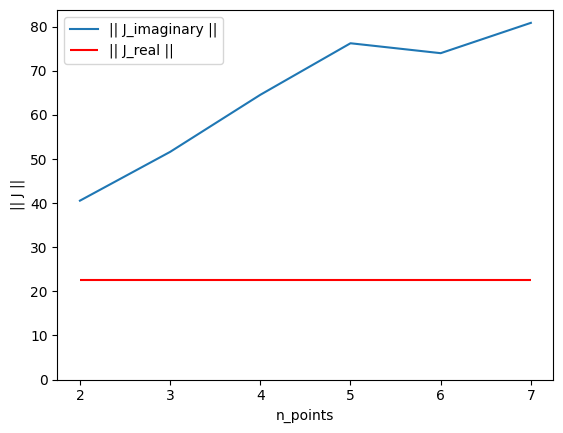

In [44]:
w_norms = [op.weight.norm().item() for op in imaginary_operators]
plt.plot(range(2, 8), w_norms, label = "|| J_imaginary ||")
plt.hlines(operator.weight.norm().item(), 2, 7, color="red", label = "|| J_real ||")
plt.ylim(bottom=0)
plt.legend()
plt.ylabel("|| J ||")
plt.xlabel("n_points")

In [45]:
operator_dict = imaginary_operators[2].__dict__.copy()
operator_dict["beta"] = 1
img_operator = operators.LinearRelationOperator(**operator_dict)

print(img_operator.weight.norm().item(), img_operator.bias.norm().item())

for sample in test.samples:
    pred = img_operator(sample.subject).predictions[:3]
    print(f"{sample} | pred: {[f'{p.token} ({p.prob:.2f})' for p in pred]}")

64.5625 225.625
Brazil -> Bras\u00edlia | pred: [' Bras (0.76)', ' Brazil (0.11)', ' Rio (0.06)']
Canada -> Ottawa | pred: [' Ottawa (0.31)', ' Canada (0.23)', ' Toronto (0.21)']
Chile -> Santiago | pred: [' Santiago (1.00)', ' Chile (0.00)', ' Buenos (0.00)']
China -> Beijing | pred: [' Beijing (0.98)', ' Shanghai (0.01)', ' China (0.01)']
Colombia -> Bogot\u00e1 | pred: [' Bog (0.60)', ' Colombia (0.31)', ' Santiago (0.03)']
Egypt -> Cairo | pred: [' Cairo (0.99)', ' Egypt (0.01)', ' Buenos (0.00)']
France -> Paris | pred: [' Paris (0.89)', ' France (0.10)', ' French (0.01)']
Japan -> Tokyo | pred: [' Tokyo (0.99)', ' Japan (0.01)', ' Osaka (0.00)']
Mexico -> Mexico City | pred: [' Mexico (1.00)', 'Mexico (0.00)', ' Buenos (0.00)']
Nigeria -> Abuja | pred: [' Mexico (0.37)', ' Nigeria (0.25)', ' Buenos (0.13)']
Spain -> Madrid | pred: [' Madrid (0.75)', ' Buenos (0.09)', ' Spain (0.09)']
Turkey -> Ankara | pred: [' Ankara (0.64)', ' Istanbul (0.35)', ' Turkey (0.01)']
United States -

Text(0.5, 0, 'n_points')

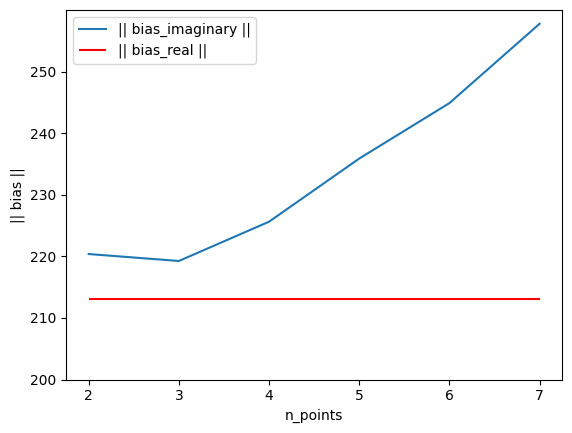

In [51]:
b_norms = [op.bias.norm().item() for op in imaginary_operators]
plt.plot(range(2, 8), b_norms, label = "|| bias_imaginary ||")
plt.hlines(operator.bias.norm().item(), 2, 7, color="red", label = "|| bias_real ||")
plt.ylim(bottom=200)
plt.legend()
plt.ylabel("|| bias ||")
plt.xlabel("n_points")

In [47]:
for sample in test.samples:
    pred = operator_i(sample.subject).predictions[:3]
    print(f"{sample} | pred: {[f'{p.token} ({p.prob:.2f})' for p in pred]}")

Brazil -> Bras\u00edlia | pred: [' Bras (0.82)', ' Brazil (0.15)', ' Rio (0.02)']
Canada -> Ottawa | pred: [' Canada (0.55)', ' Toronto (0.16)', ' Ottawa (0.15)']
Chile -> Santiago | pred: [' Santiago (1.00)', ' Chile (0.00)', ' Chilean (0.00)']
China -> Beijing | pred: [' Beijing (0.98)', ' Shanghai (0.01)', ' China (0.00)']
Colombia -> Bogot\u00e1 | pred: [' Bog (0.72)', ' Colombia (0.26)', ' Colombian (0.01)']
Egypt -> Cairo | pred: [' Cairo (0.98)', ' Egypt (0.02)', ' Egyptian (0.00)']
France -> Paris | pred: [' Paris (0.71)', ' France (0.29)', ' French (0.01)']
Japan -> Tokyo | pred: [' Tokyo (0.98)', ' Japan (0.02)', ' Japanese (0.00)']
Mexico -> Mexico City | pred: [' Mexico (1.00)', 'Mexico (0.00)', ' Mex (0.00)']
Nigeria -> Abuja | pred: [' Nigeria (0.86)', ' Abu (0.08)', ' Nigerian (0.02)']
Spain -> Madrid | pred: [' Madrid (0.83)', ' Spain (0.14)', ' Barcelona (0.01)']
Turkey -> Ankara | pred: [' Ankara (0.70)', ' Istanbul (0.27)', ' Turkey (0.03)']
United States -> Washingt

In [26]:
256 / 8

32.0

In [27]:
8 * 40

320